# <center>**Twitter Data Wrangle and Analysis - WeRateRogs**</center>
### <center>*By Tania Couture*</center>

## Table of Contents
- [Introduction](#intro)
- [Gather Data](#gather)
- [Data Assessment](#assess)
    - [Visual Assessment](#visual)
    - [Programmatic Assessment](#programmatic)
    - [Assessment Results](#results)
        - [Data Quality](#quality)
        - [Data Tidiness](#tidiness)
- [Data Cleaning](#cleaning)
- [Save Clean Data](#save)
- [Analysis](#analysis)
    -[Insight 1](#insight_1)
    -[Insight 2](#insight_2)
    -[Insight 3](#insight_3)
    -[Insight 4](#insight_4)

<a id='intro'></a>
## Introduction

WeRateDogs is a Twitter account that rates people's dogs and includes humorous comments and images.  I utilized python and its libraries to wrangle and analyze the data.


<a id='gather'></a>
## Gather Data

 **twitter_archive:** The WeRateDogs Twitter archive contains basic tweet data for all 5000+ of their tweets.  This .csv file was downloaded from Udacity via a link provided
 
 **image_predictions:** A table full of image predictions (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction generated by running the twitter archive through a neural network. This .tsv file is downloaded programatically using the *requests* library
 
 **tweet_json:** Additional tweet data such as retweet count and favourite count not included in Twitter Archive.  Lacking a twitter account and API this .txt file was downloaded from Udacity project though the code to query twitter is included 

In [288]:
#import all packages and libraries required
import requests
import pandas as pd
import json
from timeit import default_timer as timer
import validators
import re
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import tweepy
from tweepy import OAuthHandler


In [289]:
#change default column width to show all content in cells and columns
pd.set_option('display.max_colwidth', None)

#### Twitter Archive

In [290]:
# read csv into dataframe
tweets_archive = pd.read_csv('twitter-archive-enhanced.csv')

#### Image Predictions

In [291]:
# read twitter archive and download image predictions programmatically
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)
with open('image_predictions.tsv', mode = 'wb') as file:
    file.write(response.content)
    
# read tsv file
image_prediction = pd.read_csv('image_predictions.tsv', sep = '\t')



#### Tweet Json

In [292]:
# download json txt file from Udacity link
url = "https://video.udacity-data.com/topher/2018/November/5be5fb7d_tweet-json/tweet-json.txt"
response = requests.get(url)
with open('tweet_json.txt', mode = 'wb') as file:
    file.write(response.content)


In [293]:
#read json file into DataFrame line by line
tweet_list = []
with open('tweet_json.txt', 'r') as file:
    tweets = file.readlines()
    for tweet in tweets:
        json_tweet = json.loads(tweet)
        tweet_list.append({'tweet_id':json_tweet['id'],
                           'retweet_count': json_tweet['retweet_count'],
                           'favorite_count': json_tweet['favorite_count']})
        
tweet_json = pd.DataFrame(tweet_list, columns = ['tweet_id', 'retweet_count', 'favorite_count'])

<a id='assess'></a>
## Data Assessment

<a id='visual'></a> 
### Visual Assessment

In [294]:
tweets_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7,10,a,None,None,None,None


In [295]:
image_prediction

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [296]:
tweet_json

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
...,...,...,...
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132


<a id='programmatic'></a> 
### Programmatic Assessment

In [297]:
tweets_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [298]:
tweets_archive.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888022790149/photo/1,8,10,None,None,None,None,None


In [299]:
tweets_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [300]:
tweets_archive.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1012,747242308580548608,NaN,NaN,2016-06-27 01:37:04 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This pupper killed this great white in an epic sea battle. Now wears it as a trophy. Such brave. Much fierce. 13/10 https://…,7.047611e+17,4.196984e+09,2016-03-01 20:11:59 +0000,"https://twitter.com/dog_rates/status/704761120771465216/photo/1,https://twitter.com/dog_rates/status/704761120771465216/photo/1",13,10,None,None,None,pupper,None
398,825026590719483904,NaN,NaN,2017-01-27 17:04:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to Pablo. He's one gorgeous puppo. A true 12/10. Click the link to see why Pablo requests your assistance\n\nhttps://t.co/koHvVQp9bL https://t.co/IhW0JKf7kc,NaN,NaN,NaN,"https://www.gofundme.com/my-puppys-double-cataract-surgery,https://twitter.com/dog_rates/status/825026590719483904/photo/1,https://twitter.com/dog_rates/status/825026590719483904/photo/1",12,10,Pablo,None,None,None,puppo
679,789137962068021249,NaN,NaN,2016-10-20 16:15:26 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bo. He's a West Congolese Bugaboop Snuggle. Rather exotic. Master of the head tilt. 12/10 would pay to pet https://t.co/2jwxxtNzoN,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/789137962068021249/photo/1,https://twitter.com/dog_rates/status/789137962068021249/photo/1,https://twitter.com/dog_rates/status/789137962068021249/photo/1",12,10,Bo,None,None,None,None
1104,735137028879360001,NaN,NaN,2016-05-24 15:55:00 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Buckley. His family &amp; some neighbors came over to watch him perform but he's nervous af. 9/10 u got this pupper https://t.co/5bdCpPlno9,NaN,NaN,NaN,https://twitter.com/dog_rates/status/735137028879360001/photo/1,9,10,Buckley,None,None,pupper,None
1186,718540630683709445,NaN,NaN,2016-04-08 20:46:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Get you a pup that can do both. 10/10 https://t.co/zSbyvm62xZ,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/718540630683709445/photo/1,https://twitter.com/dog_rates/status/718540630683709445/photo/1",10,10,None,None,None,None,None
1573,687494652870668288,NaN,NaN,2016-01-14 04:41:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Marq. He stole this car. 7/10 wtf Marq? https://t.co/MHScqo5l8c,NaN,NaN,NaN,https://twitter.com/dog_rates/status/687494652870668288/photo/1,7,10,Marq,None,None,None,None
1231,713177543487135744,NaN,NaN,2016-03-25 01:35:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Lance. Lance doesn't give a shit. 10/10 we should all be more like Lance https://t.co/SqnG9Ap28J,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713177543487135744/photo/1,10,10,Lance,None,None,None,None
612,796904159865868288,NaN,NaN,2016-11-11 02:35:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Tyrone. He's a leaf wizard. Self-motivated. No eyes (tragic). Inspirational af. 11/10 enthusiasm is tangible https:/…,6.873173e+17,4.196984e+09,2016-01-13 16:56:30 +0000,"https://twitter.com/dog_rates/status/687317306314240000/photo/1,https://twitter.com/dog_rates/status/687317306314240000/photo/1",11,10,Tyrone,None,None,None,None
427,821153421864615936,8.211526e+17,113211856.0,2017-01-17 00:33:26 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@imgur for a polar bear tho I'd say 13/10 is appropriate,NaN,NaN,Na

In [301]:
#evaluate numerator outliers
tweets_archive[tweets_archive['rating_numerator'] > 20][['tweet_id', 'text','rating_numerator', 'rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
188,855862651834028034,@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,420,10
189,855860136149123072,"@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",666,10
290,838150277551247360,@markhoppus 182/10,182,10
313,835246439529840640,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0
340,832215909146226688,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",75,10
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,10
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27,10
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150


In [302]:
#evaluate denominator outliers
tweets_archive[tweets_archive['rating_denominator'] > 10][['tweet_id', 'text','rating_numerator', 'rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
342,832088576586297345,@docmisterio account started on 11/15/15,11,15
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
784,775096608509886464,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",9,11
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90
1254,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80


In [303]:
tweets_archive[tweets_archive['rating_denominator'] != 10][['tweet_id', 'text','rating_numerator', 'rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
313,835246439529840640,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0
342,832088576586297345,@docmisterio account started on 11/15/15,11,15
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
784,775096608509886464,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",9,11
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50


In [304]:
rating_pattern = '\d+\.\d*\/\d+'
tweets_archive[tweets_archive['text'].str.contains(rating_pattern)][['tweet_id', 'text','rating_numerator', 'rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
45,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5,10
340,832215909146226688,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",75,10
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,10
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27,10
1689,681340665377193984,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,5,10
1712,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26,10


In [305]:
text_pattern = 'RT @'
tweets_archive[tweets_archive['text'].str.contains(text_pattern)][['tweet_id', 'text','rating_numerator', 'rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
19,888202515573088257,RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX,13,10
32,886054160059072513,RT @Athletics: 12/10 #BATP https://t.co/WxwJmvjfxo,12,10
36,885311592912609280,RT @dog_rates: This is Lilly. She just parallel barked. Kindly requests a reward now. 13/10 would pet so well https://t.co/SATN4If5H5,13,10
68,879130579576475649,RT @dog_rates: This is Emmy. She was adopted today. Massive round of pupplause for Emmy and her new family. 14/10 for all involved https://…,14,10
73,878404777348136964,"RT @dog_rates: Meet Shadow. In an attempt to reach maximum zooming borkdrive, he tore his ACL. Still 13/10 tho. Help him out below\n\nhttps:/…",13,10
...,...,...,...,...
1023,746521445350707200,RT @dog_rates: This is Shaggy. He knows exactly how to solve the puzzle but can't talk. All he wants to do is help. 10/10 great guy https:/…,10,10
1043,743835915802583040,RT @dog_rates: Extremely intelligent dog here. Has learned to walk like human. Even has his own dog. Very impressive 10/10 https://t.co/0Dv…,10,10
1242,711998809858043904,RT @twitter: @dog_rates Awesome Tweet! 12/10. Would Retweet. #LoveTwitter https://t.co/j6FQGhxYuN,12,10
2259,667550904950915073,"RT @dogratingrating: Exceptional talent. Original humor. Cutting edge, Nova Scotian comedian. 12/10 https://t.co/uarnTjBeVA",12,10


In [306]:
tweets_archive[['rating_numerator','rating_denominator']].describe()

,rating_numerator,rating_denominator
count,2356.000000,2356.000000
mean,13.126486,10.455433
std,45.876648,6.745237
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


In [307]:
tweets_archive.tweet_id.duplicated().sum()

0

In [308]:
tweets_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
2         9
1         9
75        2
15        2
420       2
0         2
80        1
144       1
17        1
26        1
20        1
121       1
143       1
44        1
60        1
45        1
50        1
99        1
204       1
1776      1
165       1
666       1
27        1
182       1
24        1
960       1
84        1
88        1
Name: rating_numerator, dtype: int64

In [309]:
tweets_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
20        2
80        2
70        1
7         1
15        1
150       1
170       1
0         1
90        1
40        1
130       1
110       1
16        1
120       1
2         1
Name: rating_denominator, dtype: int64

In [310]:
tweets_archive.name.value_counts()

None          745
a              55
Charlie        12
Cooper         11
Lucy           11
             ... 
Dex             1
Ace             1
Tayzie          1
Grizzie         1
Christoper      1
Name: name, Length: 957, dtype: int64

In [311]:
name_lower = ('^[a-z]+')
not_names = tweets_archive.name.str.contains(name_lower)
tweets_archive[not_names].name.value_counts()

a               55
the              8
an               7
very             5
just             4
quite            4
one              4
getting          2
actually         2
mad              2
not              2
old              1
life             1
officially       1
light            1
by               1
infuriating      1
such             1
all              1
unacceptable     1
this             1
his              1
my               1
incredibly       1
space            1
Name: name, dtype: int64

In [312]:
tweets_archive[['tweet_id', 'text', 'name']]

,tweet_id,text,name
0,892420643555336193,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,Phineas
1,892177421306343426,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",Tilly
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,Archie
3,891689557279858688,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,Darla
4,891327558926688256,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",Franklin
...,...,...,...
2351,666049248165822465,Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,None
2352,666044226329800704,This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,a
2353,666033412701032449,Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,a
2354,666029285002620928,This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,a


In [313]:
tweets_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [314]:
tweets_archive.expanded_urls.isnull().sum()

59

In [315]:
image_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [316]:
image_prediction.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [317]:
image_prediction.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1085,718613305783398402,https://pbs.twimg.com/media/CfkG_PMWsAAH0MZ.jpg,1,Labrador_retriever,0.584580,True,German_short-haired_pointer,0.340657,True,Chesapeake_Bay_retriever,0.031975,True
990,707995814724026368,https://pbs.twimg.com/media/CdNOb17WwAA5z4A.jpg,1,agama,0.172087,False,Gila_monster,0.126978,False,lumbermill,0.050400,False
666,682788441537560576,https://pbs.twimg.com/media/CXnAdosWAAEMGCM.jpg,1,toyshop,0.375610,False,orange,0.094538,False,teddy,0.039808,False
1714,818627210458333184,https://pbs.twimg.com/media/C1xZGkzWIAA8vh4.jpg,1,Labrador_retriever,0.384188,True,beagle,0.255917,True,grocery_store,0.079799,False
1030,711306686208872448,https://pbs.twimg.com/media/Cd8Rpl0W0AAN1kU.jpg,1,leatherback_turtle,0.280835,False,loggerhead,0.123290,False,Dandie_Dinmont,0.086792,True
528,676776431406465024,https://pbs.twimg.com/ext_tw_video_thumb/676776408941662209/pu/img/k-6I3YEZAQtYPBXR.jpg,1,doormat,0.201346,False,dishwasher,0.191749,False,microwave,0.038110,False
90,667538891197542400,https://pbs.twimg.com/media/CUOTFZOW4AABsfW.jpg,1,Yorkshire_terrier,0.618957,True,silky_terrier,0.300313,True,Australian_terrier,0.053412,True
654,682059653698686977,https://pbs.twimg.com/media/CXcpovWWMAAMcfv.jpg,2,jigsaw_puzzle,0.995873,False,Siamese_cat,0.000781,False,pizza,0.000432,False
871,697943111201378304,https://pbs.twimg.com/media/Ca-XjfiUsAAUa8f.jpg,1,Great_Dane,0.126924,True,Greater_Swiss_Mountain_dog,0.110037,True,German_short-haired_pointer,0.090816,True
36,666447344410484738,https://pbs.twimg.com/media/CT-yU5QWwAEjLX5.jpg,1,curly-coated_retriever,0.322084,True,giant_schnauzer,0.287955,True,Labrador_retriever,0.166331,True


In [318]:
image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [319]:
#check that jpg urls are valid
url_check = image_prediction['jpg_url'].apply(validators.url)==True
url_check.value_counts()

True    2075
Name: jpg_url, dtype: int64

In [320]:
#check for duplicate images
image_prediction.jpg_url.duplicated().sum()

66

In [321]:
tweet_json.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [322]:
tweet_json.tail()

,tweet_id,retweet_count,favorite_count
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132
2353,666020888022790149,532,2535


In [323]:
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [324]:
tweet_json.duplicated().sum()

0

<a id='results'></a> 
### Assessment Results

<a id='quality'></a> 
#### Data Quallity

*tweets_archive:* 
- not all tweets have url links to images - remove tweets without images
- expanded_urls have duplicated links separated by delimiter in same cell - remove duplicates
- retweets created duplicate entries - remove any rows that are retweets
- columns related to retweets are not needed - remove columns
- many NaN values in table - the solutions above will fix this
- text column contains unnecessary urls - remove urls
- timestamp data type is Object - change to DateTime
- not all dog names are names - change values that are not name to None
- dog names have inconsistent capitalization - fixed when values that are not names are changed
- rating denominators have large outliers - images with multiple dogs have large denominators - remove from dataset
- some numerators have large outliers, ratings with decimals incorrect - remove novelty ratings and correct numerators that should include decimals

 
*image_predictions:* 
 - inconsistant capitalization - replace underscores with spaces and change text to titlecase
 - duplicate image urls - delete duplicate images
 - columns p1, p2, and p3 contain items that are not dogs - remove any items that are not dogs then create one column for prediction and one for predicton confidence for the prediction with the greatest confidence rating

<a id='tidiness'></a> 
#### Data Tidiness

- Columns doggo, floofer, pupper, puppo in tweets_archive can be combined into one
- All 3 DataFrames should be combined into one

<a id='cleaning'></a>
## Data Cleaning

In [325]:
#copy each Dataframe to clean
tweets = tweets_archive.copy()
images = image_prediction.copy()
tjson = tweet_json.copy()

In [326]:
#Define: remove tweets with no image urls
#Code:
tweets.drop(tweets.index[tweets['expanded_urls'].isnull()], inplace=True)
#test:
tweets.expanded_urls.isnull().sum()

0

In [327]:
#Define: remove duplicate urls in cells
#Code:
tweets['expanded_urls'] = tweets['expanded_urls'].str.split(',').apply(lambda x : ','.join(set(x)))
#Test:
tweets.expanded_urls

0       https://twitter.com/dog_rates/status/892420643555336193/photo/1
1       https://twitter.com/dog_rates/status/892177421306343426/photo/1
2       https://twitter.com/dog_rates/status/891815181378084864/photo/1
3       https://twitter.com/dog_rates/status/891689557279858688/photo/1
4       https://twitter.com/dog_rates/status/891327558926688256/photo/1
                                     ...                               
2351    https://twitter.com/dog_rates/status/666049248165822465/photo/1
2352    https://twitter.com/dog_rates/status/666044226329800704/photo/1
2353    https://twitter.com/dog_rates/status/666033412701032449/photo/1
2354    https://twitter.com/dog_rates/status/666029285002620928/photo/1
2355    https://twitter.com/dog_rates/status/666020888022790149/photo/1
Name: expanded_urls, Length: 2297, dtype: object

In [328]:
#Define: ensure image urls are valid
#Code:
url_ver = tweets['expanded_urls'].apply(validators.url)==True
#Test:
url_ver.value_counts()

True    2297
Name: expanded_urls, dtype: int64

In [329]:
#Define: remove retweets 
#Code:
tweets.drop(tweets.index[tweets['retweeted_status_id'].notnull()], inplace=True)
#Test:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2117 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2117 non-null   object 
 4   source                      2117 non-null   object 
 5   text                        2117 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2117 non-null   int64  
 11  rating_denominator          2117 non-null   int64  
 12  name                        2117 non-null   object 
 13  doggo                       2117 

In [330]:
#Define: Remove unnecessary columns
#Code:
tweets = tweets.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1)
#test - unnecessary columns have been dropped
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2117 non-null   int64 
 1   timestamp           2117 non-null   object
 2   source              2117 non-null   object
 3   text                2117 non-null   object
 4   expanded_urls       2117 non-null   object
 5   rating_numerator    2117 non-null   int64 
 6   rating_denominator  2117 non-null   int64 
 7   name                2117 non-null   object
 8   doggo               2117 non-null   object
 9   floofer             2117 non-null   object
 10  pupper              2117 non-null   object
 11  puppo               2117 non-null   object
dtypes: int64(3), object(9)
memory usage: 215.0+ KB


In [331]:
#Define: remove urls from text column
#Code: 
tweets['text'] = tweets['text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
#test - urls removed
tweets.text

0                                                            This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 
1       This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 
2                        This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 
3                                                                  This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us 
4       This is Franklin. He would like you to stop calling him "cute." He is a very fierce shark and should be respected as such. 12/10 #BarkWeek 
                                                                           ...                                                                     
2351                                              Here we have a 1949 1st generation vulpix. Enjoys sweat tea an

In [332]:
#Define: remove trailing zeroes from timestamp and change to DateTime
#Code:
tweets['timestamp'] = tweets['timestamp'].str.rstrip('+00:00:00')
#Test:
tweets.head(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek",https://twitter.com/dog_rates/status/891327558926688256/photo/1,12,10,Franklin,None,None,None,None


In [333]:
#Define: change timestamp to datetime
#Code:
tweets['timestamp'] = pd.to_datetime(tweets['timestamp'])
#Test:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2117 non-null   int64         
 1   timestamp           2117 non-null   datetime64[ns]
 2   source              2117 non-null   object        
 3   text                2117 non-null   object        
 4   expanded_urls       2117 non-null   object        
 5   rating_numerator    2117 non-null   int64         
 6   rating_denominator  2117 non-null   int64         
 7   name                2117 non-null   object        
 8   doggo               2117 non-null   object        
 9   floofer             2117 non-null   object        
 10  pupper              2117 non-null   object        
 11  puppo               2117 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 215.0+ KB


In [334]:
#Define: change not names to 'None'
#Code:
name_lower = '^[a-z]+'
tweets.name = tweets.name.str.replace(name_lower, 'None', regex=True)
#Test:
tweets.name.value_counts()

None          726
Lucy           11
Charlie        11
Cooper         10
Oliver         10
             ... 
Shelby          1
Sephie          1
Bonaparte       1
Wishes          1
Christoper      1
Name: name, Length: 931, dtype: int64

In [335]:
#Define: remove tweets with no rating
#Code:
tweets.drop(tweets[tweets['tweet_id'] == 810984652412424192].index, inplace=True)
#Test:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2116 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2116 non-null   int64         
 1   timestamp           2116 non-null   datetime64[ns]
 2   source              2116 non-null   object        
 3   text                2116 non-null   object        
 4   expanded_urls       2116 non-null   object        
 5   rating_numerator    2116 non-null   int64         
 6   rating_denominator  2116 non-null   int64         
 7   name                2116 non-null   object        
 8   doggo               2116 non-null   object        
 9   floofer             2116 non-null   object        
 10  pupper              2116 non-null   object        
 11  puppo               2116 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 214.9+ KB


In [336]:
#Define: tweets that have denominators other than 10
#Code:
tweets[tweets['rating_denominator'] != 10][['tweet_id', 'text','rating_numerator', 'rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70,84,70
902,758467244762497024,Why does this never happen at my front door... 165/150,165,150
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP",9,11
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once,204,170
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all,4,20
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10,50,50
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody,99,90
1254,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80,80,80
1274,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once",45,50
1351,704054845121142784,Here is a whole flock of puppers. 60/50 I'll take the lot,60,50


In [337]:
#Define: correct incorrect ratings
#Code:
tweets.loc[(tweets.tweet_id == 740373189193256964), 'rating_numerator'] = 14
tweets.loc[(tweets.tweet_id == 740373189193256964), 'rating_denominator'] = 10
tweets.loc[(tweets.tweet_id == 722974582966214656), 'rating_numerator'] = 13
tweets.loc[(tweets.tweet_id == 722974582966214656), 'rating_denominator'] = 10
tweets.loc[(tweets.tweet_id == 716439118184652801), 'rating_numerator'] = 11
tweets.loc[(tweets.tweet_id == 716439118184652801), 'rating_denominator'] = 10
tweets.loc[(tweets.tweet_id == 682962037429899265), 'rating_numerator'] = 10
tweets.loc[(tweets.tweet_id == 682962037429899265), 'rating_denominator'] = 10
tweets.loc[(tweets.tweet_id == 666287406224695296), 'rating_numerator'] = 9
tweets.loc[(tweets.tweet_id == 666287406224695296), 'rating_denominator'] = 10
#Test:
tweets[tweets['rating_denominator'] != 10][['tweet_id', 'text','rating_numerator', 'rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70,84,70
902,758467244762497024,Why does this never happen at my front door... 165/150,165,150
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once,204,170
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody,99,90
1254,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80,80,80
1274,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once",45,50
1351,704054845121142784,Here is a whole flock of puppers. 60/50 I'll take the lot,60,50
1433,697463031882764288,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once,44,40
1634,684225744407494656,"Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you",143,130
1635,684222868335505415,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110,121,110


In [338]:
#Define: remove ratings for imagines with multiple dogs
#Code:
tweets.drop(tweets.index[tweets['rating_denominator'] != 10], inplace=True)
#Test
tweets[tweets['rating_denominator'] != 10][['tweet_id', 'text','rating_numerator', 'rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator


In [339]:
#Define: re-evaluate numerators
#Code:
tweets.rating_numerator.value_counts()

12      489
10      437
11      418
13      296
9       154
8        98
7        51
14       41
5        34
6        32
3        19
4        15
2         9
1         4
0         2
27        1
75        1
1776      1
26        1
420       1
Name: rating_numerator, dtype: int64

Numerator 1776 Image
![Image of 749981277374128128](https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD?format=jpg&name=small)
Numerator 420 Image
![Image of 670842764863651840](https://pbs.twimg.com/media/CU9P717W4AAOlKx?format=jpg&name=small
)

In [340]:
#Define: delete numerator outliers - good looking american af Atticus and Snopp Dogg
#Code:
tweets.drop(tweets[tweets['rating_numerator'] == 1776].index, inplace=True)
tweets.drop(tweets[tweets['rating_numerator'] == 420].index, inplace=True)
#Test
tweets.rating_numerator.value_counts()

12    489
10    437
11    418
13    296
9     154
8      98
7      51
14     41
5      34
6      32
3      19
4      15
2       9
1       4
0       2
75      1
26      1
27      1
Name: rating_numerator, dtype: int64

In [341]:
#Test:
tweets[tweets['rating_numerator'] >10][['tweet_id', 'text','rating_numerator', 'rating_denominator', 'expanded_urls']]

,tweet_id,text,rating_numerator,rating_denominator,expanded_urls
0,892420643555336193,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10,13,10,https://twitter.com/dog_rates/status/892420643555336193/photo/1
1,892177421306343426,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10",13,10,https://twitter.com/dog_rates/status/892177421306343426/photo/1
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10,12,10,https://twitter.com/dog_rates/status/891815181378084864/photo/1
3,891689557279858688,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us,13,10,https://twitter.com/dog_rates/status/891689557279858688/photo/1
4,891327558926688256,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek",12,10,https://twitter.com/dog_rates/status/891327558926688256/photo/1
...,...,...,...,...,...
2307,666826780179869698,12/10 simply brilliant pup,12,10,https://twitter.com/dog_rates/status/666826780179869698/photo/1
2324,666421158376562688,*internally screaming* 12/10,12,10,https://twitter.com/dog_rates/status/666421158376562688/photo/1
2329,666373753744588802,Those are sunglasses and a jean jacket. 11/10 dog cool af,11,10,https://twitter.com/dog_rates/status/666373753744588802/photo/1
2336,666273097616637952,Can take selfies 11/10,11,10,https://twitter.com/dog_rates/status/666273097616637952/photo/1


In [342]:
#Define: locate ratings in text that have decimals
#Code:
rating_pattern = '\d+\.\d*\/\d+'
tweets[tweets['text'].str.contains(rating_pattern)][['tweet_id', 'text','rating_numerator', 'rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
45,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10",5,10
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10",75,10
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back,27,10
1712,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10,26,10


In [343]:
#Define: change rating_numerator and rating_denominator to float to allow for decimals
#Code:
tweets[['rating_numerator', 'rating_denominator']] = tweets[['rating_numerator', 'rating_denominator']].astype(float)
#Test:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2102 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2102 non-null   int64         
 1   timestamp           2102 non-null   datetime64[ns]
 2   source              2102 non-null   object        
 3   text                2102 non-null   object        
 4   expanded_urls       2102 non-null   object        
 5   rating_numerator    2102 non-null   float64       
 6   rating_denominator  2102 non-null   float64       
 7   name                2102 non-null   object        
 8   doggo               2102 non-null   object        
 9   floofer             2102 non-null   object        
 10  pupper              2102 non-null   object        
 11  puppo               2102 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(8)
memory usage: 213.5+ KB


In [344]:
#Define: Correct ratings for decimals
#Code:
tweets.loc[(tweets.tweet_id == 883482846933004288), 'rating_numerator'] = 13.5
tweets.loc[(tweets.tweet_id == 786709082849828864), 'rating_numerator'] = 9.75
tweets.loc[(tweets.tweet_id == 778027034220126208), 'rating_numerator'] = 11.27
tweets.loc[(tweets.tweet_id == 680494726643068929), 'rating_numerator'] = 11.26
#Test:
rating_pattern = '\d+\.\d*\/\d+'
tweets[tweets['text'].str.contains(rating_pattern)][['tweet_id', 'text','rating_numerator', 'rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
45,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10",13.50,10.0
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10",9.75,10.0
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back,11.27,10.0
1712,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10,11.26,10.0


In [345]:
#Test
tweets.rating_numerator.value_counts()

12.00    489
10.00    437
11.00    418
13.00    296
9.00     154
8.00      98
7.00      51
14.00     41
5.00      33
6.00      32
3.00      19
4.00      15
2.00       9
1.00       4
0.00       2
9.75       1
11.27      1
13.50      1
11.26      1
Name: rating_numerator, dtype: int64

In [346]:
#Define: remove underscores and format text to titlecase
#Code:
images.p1 = images.p1.str.replace('_', ' ').str.title()
images.p2 = images.p2.str.replace('_', ' ').str.title()
images.p3 = images.p3.str.replace('_', ' ').str.title()
#Test
images.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh Springer Spaniel,0.465074,True,Collie,0.156665,True,Shetland Sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,Miniature Pinscher,0.074192,True,Rhodesian Ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German Shepherd,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian Ridgeback,0.408143,True,Redbone,0.360687,True,Miniature Pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature Pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [347]:
#Define: remove duplicate images that are rated the same
#Code:
images=images.drop_duplicates(subset=['jpg_url', 'p1', 'p2', 'p3'], keep='last')
#test
images.jpg_url.duplicated().sum()

0

In [348]:
#Define: if there are rows where all _dog values are False meaning no dogs in predictions
#Code:
images[images['p1_dog'] == False][['p1', 'p1_conf','p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog']]

,p1,p1_conf,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,Box Turtle,0.933012,Mud Turtle,0.045885,False,Terrapin,0.017885,False
8,Shopping Cart,0.962465,Shopping Basket,0.014594,False,Golden Retriever,0.007959,True
17,Hen,0.965932,Cock,0.033919,False,Partridge,0.000052,False
18,Desktop Computer,0.086502,Desk,0.085547,False,Bookcase,0.079480,False
21,Three-Toed Sloth,0.914671,Otter,0.015250,False,Great Grey Owl,0.013207,False
...,...,...,...,...,...,...,...,...
2026,Web Site,0.949591,Dhole,0.017326,False,Golden Retriever,0.006941,True
2046,Convertible,0.738995,Sports Car,0.139952,False,Car Wheel,0.044173,False
2052,Limousine,0.130432,Tow Truck,0.029175,False,Shopping Cart,0.026321,False
2071,Paper Towel,0.170278,Labrador Retriever,0.168086,True,Spatula,0.040836,False


In [349]:
#Define: remove rows that do not have dogs in the predictions
#Code:
images = images.drop(images[(images['p1_dog'] == False) & (images['p2_dog'] == False) & (images['p3_dog'] == False)].index)   
#Test:
images[images['p1_dog'] == False][['p1', 'p1_conf','p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog']]

,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
8,Shopping Cart,0.962465,False,Shopping Basket,0.014594,False,Golden Retriever,0.007959,True
22,Ox,0.416669,False,Newfoundland,0.278407,True,Groenendael,0.102643,True
33,Llama,0.505184,False,Irish Terrier,0.104109,True,Dingo,0.062071,False
43,Seat Belt,0.375057,False,Miniature Pinscher,0.167175,True,Chihuahua,0.086951,True
52,Hay,0.507637,False,Rottweiler,0.062490,True,Water Buffalo,0.048425,False
...,...,...,...,...,...,...,...,...,...
1984,Basketball,0.808396,False,Pug,0.066736,True,Dalmatian,0.054570,True
1992,Laptop,0.153718,False,French Bulldog,0.099984,True,Printer,0.077130,False
2013,Tricycle,0.663601,False,Labrador Retriever,0.033496,True,Pembroke,0.018827,True
2026,Web Site,0.949591,False,Dhole,0.017326,False,Golden Retriever,0.006941,True


In [350]:
#Define: if p1 results in False p1_dog, replace values with highest confidence True values from p2 and p3
#Code:
images.loc[(images.p1_dog == False), 'p1'] = images['p2']
images.loc[(images.p1_dog == False), 'p1_conf'] = images['p2_conf']
images.loc[(images.p1_dog == False), 'p1_dog'] = images['p2_dog']
images.loc[(images.p1_dog == False), 'p1'] = images['p3']
images.loc[(images.p1_dog == False), 'p1_conf'] = images['p3_conf']
images.loc[(images.p1_dog == False), 'p1_dog'] = images['p3_dog']
#Test - all values in p1_dog are True meaning all p1 values are dogs
images.p1_dog.value_counts()

True    1691
Name: p1_dog, dtype: int64

In [351]:
#Define: rename p1 and p1_conf
#Code:
images.rename(columns={'p1': 'prediction', 'p1_conf': 'prediction_conf'}, inplace=True)

In [352]:
#Define: drop p1_dog to p3_dog columns as no longer needed
#Code:
images.drop(columns=['p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], inplace=True)
#Test
images.head()

,tweet_id,jpg_url,img_num,prediction,prediction_conf
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh Springer Spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German Shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian Ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature Pinscher,0.560311


In [353]:
#Define: Pull dog stage from text matching WeRateDogs stages
#Code:
stage_pattern = '(doggo|floofer|pupper|puppo)'
tweets['dog_stage'] = tweets['text'].str.extract(stage_pattern)
#Test:
tweets.dog_stage.value_counts()

pupper     236
doggo       80
puppo       29
floofer      4
Name: dog_stage, dtype: int64

In [354]:
#Define: replace Nan values with 'None' to keep consistancy
#Code:
tweets.dog_stage = tweets.dog_stage.fillna('None')

In [355]:
#Define: drop unneeded individual dog stage columns
#Code:
tweets.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)
#Test:
tweets.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,None
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,None
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,None
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10.0,Darla,None
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek",https://twitter.com/dog_rates/status/891327558926688256/photo/1,12.0,10.0,Franklin,None


In [356]:
#Define: Combine Dataframes tweets and images)
#Code:
merge_1 = pd.merge(tweets, images, how = 'inner', on = ['tweet_id'])
#Test:
merge_1.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,jpg_url,img_num,prediction,prediction_conf
0,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581
1,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012
2,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10.0,Darla,None,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,Labrador Retriever,0.168086
3,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek",https://twitter.com/dog_rates/status/891327558926688256/photo/1,12.0,10.0,Franklin,None,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,Basset,0.555712
4,891087950875897856,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13.0,10.0,None,None,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake Bay Retriever,0.425595


In [357]:
#Test:
merge_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1614 entries, 0 to 1613
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1614 non-null   int64         
 1   timestamp           1614 non-null   datetime64[ns]
 2   source              1614 non-null   object        
 3   text                1614 non-null   object        
 4   expanded_urls       1614 non-null   object        
 5   rating_numerator    1614 non-null   float64       
 6   rating_denominator  1614 non-null   float64       
 7   name                1614 non-null   object        
 8   dog_stage           1614 non-null   object        
 9   jpg_url             1614 non-null   object        
 10  img_num             1614 non-null   int64         
 11  prediction          1614 non-null   object        
 12  prediction_conf     1614 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(2), obje

In [358]:
#Define: Merge DataFrames merge_1 and tjson
#Code:
twitter_dogs = pd.merge(merge_1, tjson, how = 'inner', on = ['tweet_id'])
#Test:
twitter_dogs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1614 entries, 0 to 1613
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1614 non-null   int64         
 1   timestamp           1614 non-null   datetime64[ns]
 2   source              1614 non-null   object        
 3   text                1614 non-null   object        
 4   expanded_urls       1614 non-null   object        
 5   rating_numerator    1614 non-null   float64       
 6   rating_denominator  1614 non-null   float64       
 7   name                1614 non-null   object        
 8   dog_stage           1614 non-null   object        
 9   jpg_url             1614 non-null   object        
 10  img_num             1614 non-null   int64         
 11  prediction          1614 non-null   object        
 12  prediction_conf     1614 non-null   float64       
 13  retweet_count       1614 non-null   int64       

In [359]:
#Test:
twitter_dogs.sample(15)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,jpg_url,img_num,prediction,prediction_conf,retweet_count,favorite_count
89,869596645499047938,2017-05-30 16:49:31,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Scout. He just graduated. Officially a doggo now. Have fun with taxes and losing sight of your ambitions. 12/10 would throw cap for,https://twitter.com/dog_rates/status/869596645499047938/photo/1,12.0,10.0,Scout,doggo,https://pbs.twimg.com/media/DBFtiYqWAAAsjj1.jpg,1,Chihuahua,0.955156,3327,16476
288,819588359383371776,2017-01-12 16:54:26,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Jazzy. She just found out that sandwich wasn't for her. Shocked and puppalled. 13/10 deep breaths Jazzy,https://twitter.com/dog_rates/status/819588359383371776/photo/1,13.0,10.0,Jazzy,None,https://pbs.twimg.com/media/C1_DQn3UoAIoJy7.jpg,1,Cardigan,0.547935,2271,10606
1221,676582956622721024,2015-12-15 02:02:01,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Meet Vinnie. He's having fun while being safe. Well not a lot of fun, but definitely safe, and that's important 8/10",https://twitter.com/dog_rates/status/676582956622721024/photo/1,8.0,10.0,Vinnie,None,https://pbs.twimg.com/media/CWO0m8tUwAAB901.jpg,1,Boston Bull,0.196307,312,1310
650,743980027717509120,2016-06-18 01:33:55,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Geno. He's a Wrinkled Baklavian Velveeta. Looks sad but that's just the extra skin. 11/10 would smoosh face,https://twitter.com/dog_rates/status/743980027717509120/photo/1,11.0,10.0,Geno,None,https://pbs.twimg.com/media/ClMl4VLUYAA5qBb.jpg,1,Bull Mastiff,0.975730,1231,4551
512,767754930266464257,2016-08-22 16:06:54,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Philbert. His toilet broke and he doesn't know what to do. Trying not to panic. 11/10 furustrated af,https://twitter.com/dog_rates/status/767754930266464257/photo/1,11.0,10.0,Philbert,None,https://pbs.twimg.com/media/CqedCQWWgAIab9L.jpg,1,Vizsla,0.307794,6221,17814
88,869702957897576449,2017-05-30 23:51:58,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Stanley. He likes road trips. Will shift for you. One ear more effective than other. 13/10 we don't leave until you buckle pup Stanley,https://twitter.com/dog_rates/status/869702957897576449/photo/1,13.0,10.0,Stanley,None,https://pbs.twimg.com/media/DBHOOfOXoAABKlU.jpg,1,Pembroke,0.993449,6728,29116
275,822610361945911296,2017-01-21 01:02:48,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Please stop sending in non-canines like this Very Pettable Dozing Bath Tortoise. We only rate dogs. Only send dogs... 12/10,https://twitter.com/dog_rates/status/822610361945911296/photo/1,12.0,10.0,None,None,https://pbs.twimg.com/media/C2p_wQyXEAELtvS.jpg,1,Cocker Spaniel,0.664487,3423,16327
661,741438259667034112,2016-06-11 01:13:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Tucker. He's still figuring out couches. 9/10 keep your head up pup,https://twitter.com/dog_rates/status/741438259667034112/photo/1,9.0,10.0,Tucker,None,https://pbs.twimg.com/media/CkoeKTPWYAAcWmo.jpg,1,Chesapeake Bay Retriever,0.292675,937,4026
1523,668113020489474048,2015-11-21 17:05:31,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Alfie. He's that one hypocritical gym teacher who made you run laps. Great posture. Cool bench. 6/10,https://twitter.com/dog_rates/status/668113020489474048/photo/1,6.0,10.0,Alfie,None,https://pbs.twimg.com/media/CUWdPsqWcAERQVv.jpg,1,Pembroke,0.548896,265,709
1508,668507509523615744,2015-11-22 19:13:05,"<a href=""http://twitter.com/download/iphone"" rel=""n

<a id='save'></a>
## Save Clean Data

In [360]:
#Store final DataFrame to csv
twitter_dogs.to_csv('twitter_archive_master.csv')

<a id='analysis'></a>
## Analysis

<a id='insight_1'></a>
### Insight 1

#### The most common dog breed based on image prediction is the Golden Retriever with 140 counts.  The Labrador Retriever is second with 100 counts, while 8 breeds are tied for the least common breed all with 1 count.

In [361]:
twitter_dogs.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,jpg_url,img_num,prediction,prediction_conf,retweet_count,favorite_count
0,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,6514,33819
1,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,4328,25461
2,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10.0,Darla,None,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,Labrador Retriever,0.168086,8964,42908
3,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek",https://twitter.com/dog_rates/status/891327558926688256/photo/1,12.0,10.0,Franklin,None,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,Basset,0.555712,9774,41048
4,891087950875897856,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13.0,10.0,None,None,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake Bay Retriever,0.425595,3261,20562


In [362]:
twitter_dogs.prediction.value_counts()

Golden Retriever        140
Labrador Retriever      100
Pembroke                 94
Chihuahua                87
Pug                      60
                       ... 
Silky Terrier             1
Scotch Terrier            1
Bouvier Des Flandres      1
Clumber                   1
Irish Wolfhound           1
Name: prediction, Length: 113, dtype: int64

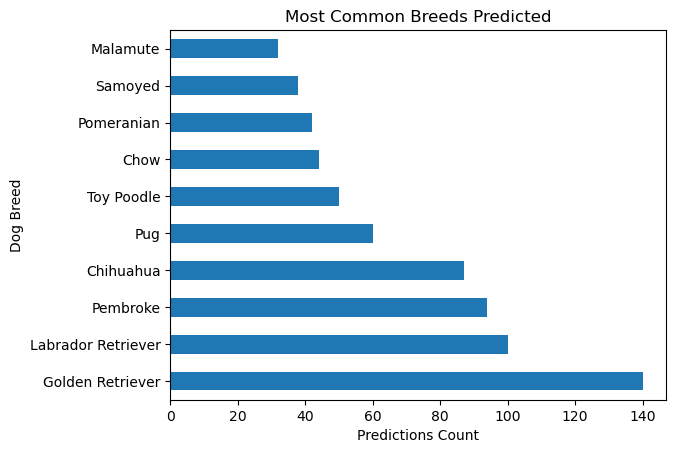

In [363]:
twitter_dogs['prediction'].value_counts()[:10].plot(kind='barh')
plt.title('Most Common Breeds Predicted')
plt.xlabel('Predictions Count')
plt.ylabel('Dog Breed')
plt.savefig('top_breed.png', bbox_inches='tight')
plt.show();


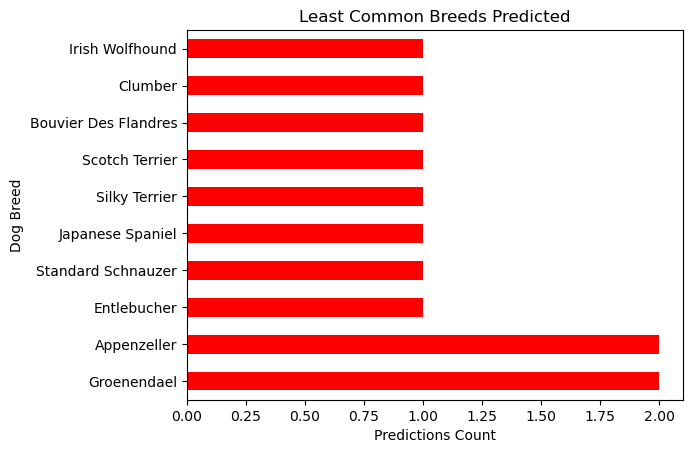

In [364]:
twitter_dogs['prediction'].value_counts()[-10:].plot(kind='barh', color='red')
plt.title('Least Common Breeds Predicted')
plt.xlabel('Predictions Count')
plt.ylabel('Dog Breed')
plt.savefig('bottom_breed.png', bbox_inches='tight')
plt.show();

<a id='insight_2'></a>
### Insight 2

#### The top 5 dog names are: Charlie, Lucy, Cooper, Oliver, and Tucker.  
#### The bottom 5 dog names are: Shadoe, Angel, Brat, Tove, and Christopher.

In [365]:
twitter_dogs.name.value_counts().head(6)

None       472
Charlie     10
Lucy        10
Cooper      10
Oliver       9
Tucker       8
Name: name, dtype: int64

In [366]:
twitter_dogs.name.value_counts().tail(5)

Shadoe        1
Angel         1
Brat          1
Tove          1
Christoper    1
Name: name, dtype: int64

<a id='insight_3'></a>
### Insight 3

#### There is a positive correlation between retweet counts and favourite counts

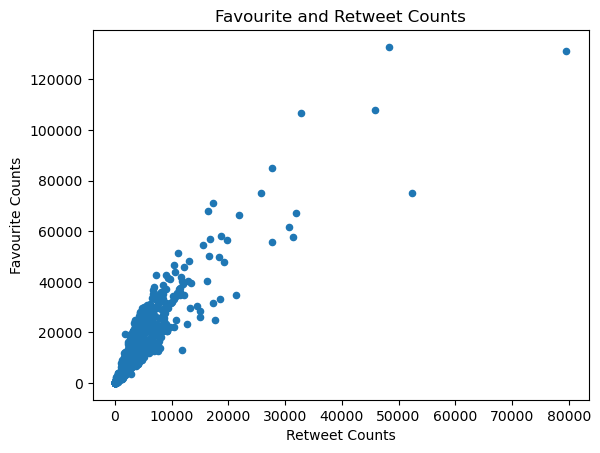

In [367]:
twitter_dogs.plot(x='retweet_count', y='favorite_count', kind='scatter')
plt.xlabel('Retweet Counts')
plt.ylabel('Favourite Counts')
plt.title('Favourite and Retweet Counts')

plt.savefig('retweet_vs_favourite', bbox_inches='tight')
plt.show();


<a id='insight_4'></a>
### Insight 4

#### The dog breed predictions with the greatest prediction confidence are Komodor, Clumber, keeshond, Bull Mastiff, Brittany Spaniel, Bernese Mountain Dog, Tibetan Mastiff, samoyed, Blenheim Spaniel and German Shepherd

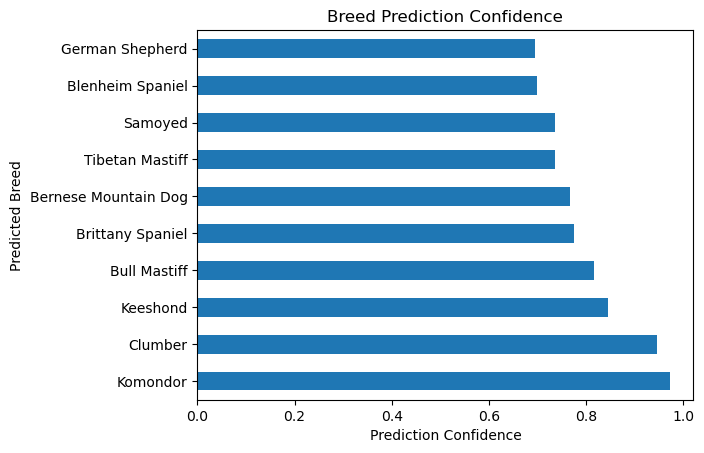

<Figure size 640x480 with 0 Axes>

In [368]:
breed_conf=twitter_dogs.groupby(['prediction'])
breed_conf=breed_conf['prediction_conf'].mean().sort_values(ascending = False)
breed_conf.head(10).plot(kind='barh')
plt.title('Breed Prediction Confidence')
plt.xlabel('Prediction Confidence')
plt.ylabel('Predicted Breed')
plt.savefig('breed_prediction.png', bbox_inches='tight')
plt.show();
plt.savefig('Breed Prediction Confidence', bbox_inches='tight')
plt.show();


<a id='insight_5'></a>
### Insight 5

#### As the count of each dog stage increases the mean decreases and the standard deviation increases.

In [369]:
stats = twitter_dogs.groupby('dog_stage')['rating_numerator'].describe()
stats

,count,mean,std,min,25%,50%,75%,max
dog_stage,,,,,,,,
None,1354.0,10.734505,1.824415,0.0,10.0,11.0,12.0,14.0
doggo,58.0,11.672414,1.668994,5.0,11.0,12.0,13.0,14.0
floofer,3.0,12.666667,0.577350,12.0,12.5,13.0,13.0,13.0
pupper,173.0,10.799191,1.418506,6.0,10.0,11.0,12.0,14.0
puppo,26.0,12.115385,1.243444,9.0,12.0,12.5,13.0,14.0


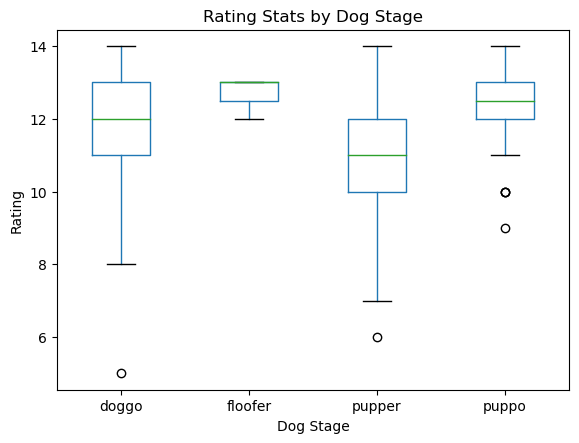

In [370]:
twitter_dog_stage = twitter_dogs[twitter_dogs.dog_stage != 'None']
twitter_dog_stage.boxplot(by ='dog_stage', column =['rating_numerator'], grid = False)
plt.title('Rating Stats by Dog Stage')
plt.suptitle('')
plt.xlabel('Dog Stage')
plt.ylabel('Rating')
plt.savefig('ratings_by_stage.png', bbox_inches='tight')
plt.show();